## Run The Circuit on a Quantum Provider

#### Build The time dependent Hamiltonian

Imports and Routines

In [2]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict



def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.5*t_val) )
            YY_tuples.append(("YY", [i, j], 0.5*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()


Loading the parameters of $H_Q$

In [3]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]
    
print(t_onebody)

t_onebody.pop((0,1))
t_onebody.pop((0,2))
t_onebody.pop((1,2))

print(t_onebody)

{(0, 0): -26.722099999999998, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): -26.722099999999998, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -23.4103}
{(0, 0): -26.722099999999998, (1, 0): 1.0430999999999995, (1, 1): -26.722099999999998, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -23.4103}


Compute $H_Q$

In [4]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)

Compute $H_D$

In [5]:
coupling_term=-26.7221
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


#### Build the circuit

In [ ]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])

In [20]:
transpiled_circuit_time_evolution.draw()

global phase: 1.5993
       ┌────────────┐  ┌──────────┐┌───┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ──┤ Rz(3.1341) ├──┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/2) ├┤ Rz(3π/2) ├┤ Rz(-π/2) ├»
     ┌─┴────────────┴─┐└──┬───┬───┘└───┘└──────────┘└──────────┘└──────────┘»
q_1: ┤ Rz(0.00057002) ├───┤ H ├─────────────────────────────────────────────»
     └┬─────────────┬─┘┌──┴───┴───┐┌───┐┌──────────┐┌──────────┐┌──────────┐»
q_2: ─┤ Rz(-2.5802) ├──┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/2) ├┤ Rz(3π/2) ├┤ Rz(-π/2) ├»
      └─────────────┘  └──────────┘└───┘└──────────┘└──────────┘└──────────┘»
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐┌──────────┐┌────────┐     ┌──────────────┐┌──────────┐┌───┐»
«q_0: ┤ H ├┤ Rz(-π/2) ├┤ Rz(3π) ├──■──┤ Rz(-0.21152) ├┤ Rz(-π/2) ├┤ H ├»
«     └───┘└──────────┘└────────┘  │  └──────────────┘└──────────┘└───┘»
«q_1: ─────────────────────────────┼───────────────────────────────────»
«     ┌───┐┌──────────┐┌────────┐┌─┴─┐┌─────────────┐ ┌──────────┐┌───┐»
«q_2: ┤ H ├┤ Rz(-π/2) ├┤ Rz(2π) ├┤ X ├┤ Rz(-1.5722) ├─┤ Rz(-π/2) ├┤ H ├»
«     └───┘└──────────┘└────────┘└───┘└─────────────┘ └──────────┘└───┘»
«c: 3/═════════════════════════════════════════════════════════════════»
«                                                                      »
«     ┌──────────┐  ┌────────┐  ┌──────────┐┌───┐┌──────────┐┌────────────┐»
«q_0: ┤ Rz(-π/2) ├──┤ Rz(2π) ├──┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/2) ├┤ Rz(7.6425) ├»
«     └──────────┘  └────────┘  └──────────┘└───┘└──────────┘└────────────┘»
«q_1: ─────────────────────────────────────────────────────────────────────»
«     ┌──────────┐┌────────────┐┌──────────┐┌───┐┌──────────┐┌────────────┐»
«q_2: ┤ Rz(-π/2) ├┤ Rz(4.7124) ├┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/2) ├┤ Rz(10.996) ├»
«     └──────────┘└────────────┘└──────────┘└───┘└──────────┘└────────────┘»
«c: 3/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«           ┌───────┐  ┌──────────┐┌───┐┌──────────┐┌────────────┐┌──────────┐»
«q_0: ──■───┤ Rz(0) ├──┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/2) ├┤ Rz(6.2786) ├┤ Rz(-π/2) ├»
«       │   └───────┘  └──────────┘└───┘└──────────┘└────────────┘└──────────┘»
«q_1: ──┼─────────────────────────────────────────────────────────────────────»
«     ┌─┴─┐┌──────────┐┌──────────┐┌───┐┌──────────┐┌───────────┐ ┌──────────┐»
«q_2: ┤ X ├┤ Rz(-π/2) ├┤ Rz(-π/2) ├┤ H ├┤ Rz(-π/2) ├┤ Rz(4.151) ├─┤ Rz(-π/2) ├»
«     └───┘└──────────┘└──────────┘└───┘└──────────┘└───────────┘ └──────────┘»
«c: 3/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌───┐┌──────────┐┌──────────┐                                 »
«q_0: ┤ H ├┤ Rz(-π/2) ├┤ Rz(7π/2) ├─────────────────────────────────»
«     └───┘└──────────┘└──────────┘                            ┌───┐»
«q_1: ───────────────────────────────■──────────────────────■──┤ H ├»
«     ┌───┐┌──────────┐┌──────────┐┌─┴─┐┌────────────────┐┌─┴─┐├───┤»
«q_2: ┤ H ├┤ Rz(-π/2) ├┤ Rz(5π/2) ├┤ X ├┤ Rz(0.00089022) ├┤ X ├┤ H ├»
«     └───┘└──────────┘└──────────┘└───┘└────────────────┘└───┘└───┘»
«c: 3/══════════════════════════════════════════════════════════════»
«                                                                   »
«                                                                ┌──────────┐»
«q_0: ─────────────────────────────■──────────────────────────■──┤ Rz(-π/2) ├»
«     ┌───────────────┐┌───┐     ┌─┴─┐     ┌───────────────┐┌─┴─┐└──┬───┬───┘»
«q_1: ┤ Rz(0.0019227) ├┤ H ├─────┤ X ├─────┤ Rz(0.0011037) ├┤ X ├───┤ H ├────»
«     ├───────────────┤├───┤┌────┴───┴────┐└──┬──────────┬─┘├───┤┌──┴───┴───┐»
«q_2: ┤ Rz(0.0032518) ├┤ H ├┤ Rz(-1.0094) ├───┤ Rz(-π/2) ├──┤ H ├┤ Rz(-π/2) ├»
«     └───────────────┘└───┘└─────────────┘   └──────────┘  └───┘└──────────┘»
«c: 3/══════════════════

#### Perform Measurement Shots using an IBM fake provider

In [21]:
z_measure_QA_circuit=transpiled_circuit_time_evolution.copy()
z_measure_QA_circuit.measure([0, 1, 2], [0, 1, 2])
z_measure_QA_circuit.measure_all()



#### Classical Backend

In [22]:
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Replace with your actual API token
#provider = IBMProvider(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
# backends = provider.backends()
# for backend in backends:
#     print(backend.name)
    

    
# Load the service
service = QiskitRuntimeService()
backend = FakeManilaV2()
#backend=StatevectorSimulator()
 
sampler = Sampler(backend)
options = sampler.options
# Turn on gate twirling.
options.twirling.enable_gates = True
options.twirling.num_randomizations = 32
options.twirling.shots_per_randomization = 100
#options.resilience.pec_mitigation = True
#options.resilience.pec_mitigation = True
#options.dynamical_decoupling.enable = True
#options.dynamical_decoupling.sequence_type = "XpXm"

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

transpiled_qc=pm.run(z_measure_QA_circuit)

transpiled_qc.draw()

#print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


job = sampler.run([(transpiled_qc)],shots=1000)
result = job.result()

/tmp/ipykernel_1740301/3329547704.py:17: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


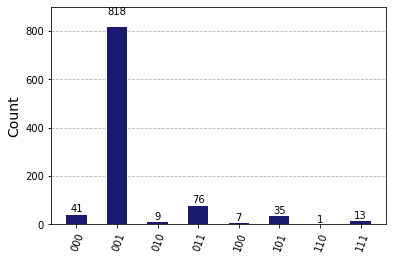

In [23]:
import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram
%matplotlib inline

counts=result[0].data.c.get_counts()
plot_histogram(counts,color='midnightblue')
